# PopStar Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the PopStar package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation with all the available options to the user at each step is provided in [XXX].

Before starting this tutorial, it is assumed that PopStar has been installed and the user's python path has been altered to include the PopStar top-level directory

In [1]:
# Import necessary packages. 
from popstar import synthetic, evolution, atmospheres, reddening
from popstar.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb

/anaconda3/envs/astroconda/lib/python3.6/site-packages/matplotlib/__init__.py:850: MatplotlibDeprecationWarning: 
The text.dvipnghack rcparam was deprecated in Matplotlib 2.1 and will be removed two minor releases later.
  version, name=key, obj_type="rcparam", alternative=alt_key)
/anaconda3/envs/astroconda/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /u/mwhosek/test/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/anaconda3/envs/astroconda/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /u/mwhosek/test/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


#### Step 1: Make a PopStar isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth.

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec

# Define evolution/atmosphere models and extinction law (optional)
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

Changing to logg=4.0 for T= 32651 logg=3.99
Changing to logg=4.0 for T= 32840 logg=3.98
Changing to logg=4.0 for T= 33037 logg=3.97
Changing to logg=4.0 for T= 33144 logg=3.96
Changing to logg=4.0 for T= 33205 logg=3.95
Changing to logg=4.0 for T= 33358 logg=3.94
Changing to logg=4.0 for T= 33504 logg=3.93
Changing to logg=4.0 for T= 33651 logg=3.91
Changing to logg=4.0 for T= 33713 logg=3.91
Changing to logg=4.0 for T= 33775 logg=3.90
Changing to logg=4.0 for T= 33892 logg=3.89
Changing to logg=4.0 for T= 34002 logg=3.87
Changing to logg=4.0 for T= 34111 logg=3.86
Changing to logg=4.0 for T= 34182 logg=3.85
Changing to logg=4.0 for T= 34222 logg=3.85
Changing to logg=4.0 for T= 34332 logg=3.83
Changing to logg=4.0 for T= 34443 logg=3.82
Changing to logg=4.0 for T= 34546 logg=3.81
Changing to logg=4.0 for T= 34658 logg=3.80
Changing to logg=4.0 for T= 34674 logg=3.80
Changing to logg=4.0 for T= 34746 logg=3.79
Changing to logg=4.0 for T= 34842 logg=3.78
Changing to logg=4.0 for T= 3493

Changing to logg=5.0 for T= 33504 logg=5.13
Changing to logg=5.0 for T= 33466 logg=5.08
Changing to logg=5.0 for T= 33504 logg=5.08
Changing to logg=5.0 for T= 33558 logg=5.07
Changing to logg=5.0 for T= 33605 logg=5.08
Changing to logg=5.0 for T= 33651 logg=5.08
Changing to logg=5.0 for T= 33674 logg=5.07
Changing to logg=5.0 for T= 32870 logg=5.05
Changing to logg=5.0 for T= 30054 logg=5.01
Changing to logg=5.0 for T= 29819 logg=5.01
Changing to logg=5.0 for T= 35785 logg=5.39
Changing to logg=5.0 for T= 39683 logg=5.62
Changing to logg=5.0 for T= 39701 logg=5.62
Changing to logg=5.0 for T= 39655 logg=5.63
Changing to logg=5.0 for T= 39518 logg=5.63
Changing to logg=5.0 for T= 39373 logg=5.63
Changing to logg=5.0 for T= 39518 logg=5.65
Changing to logg=5.0 for T= 40031 logg=5.69
Changing to logg=5.0 for T= 40096 logg=5.70
Changing to logg=5.0 for T= 40495 logg=5.74
Changing to logg=5.0 for T= 41381 logg=5.82
Changing to logg=5.0 for T= 41976 logg=5.87
Changing to logg=5.0 for T= 4219

Changing temp from 57703 to 50000
Changing to logg=5.0 for T= 50000 logg=6.11
Changing temp from 57850 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 57983 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 58117 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 58251 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58398 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58546 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58695 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58844 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 58993 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 59143 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 59293 to 50000
Changing to logg=5.0 for T= 50000 logg=6.15
Changing temp from 59334 to 50000
Changing to logg=5.0 for T= 50

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (not shown here; default location is current working directory). In future code calls, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The file name will be the following: "iso_logAge_AKs_distance.fits, using the specified values

In [3]:
# The individual points in the isochrone can be accessed using the points subfunction 
# on the isochrone object. This produces an astropy table that contains the 
# list of stellar masses in the isochrone and their associated properties
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
 6.591312905046435e+24  2928.195035574271 ... 21.454393405994317
  7.13135291244921e+24 2943.7437337117412 ... 21.366522688728868
 7.761969450327467e+24 2958.6936525140045 ... 21.272755867654716
 8.296060854703104e+24  2975.089258880875 ... 21.199052286364093
 8.830228238420424e+24  2992.264636608189 ... 21.130349503148018
 8.860779496066351e+24  3009.539168873201 ...   21.1268524903858
 8.889389363240369e+24  3026.913428101305 ...  21.12475106804226
1.1365065135674554e+25  3065.490679425787 ...   20.8616374881783
1.3837955482036446e+25  3103.844819159537 ...  20.65220438788622
 1.631443091163686e+25  3142.678829879227 ...     20.46963686363
                   ...                ... ...                ...
2.0430167585847428e+32  61503.52393069763 ... 11.147069143378806
2.0524468954776198e+32  6

In [4]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [5]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.051 mag, F139M = 18.453 mag, F153M = 17.785 mag


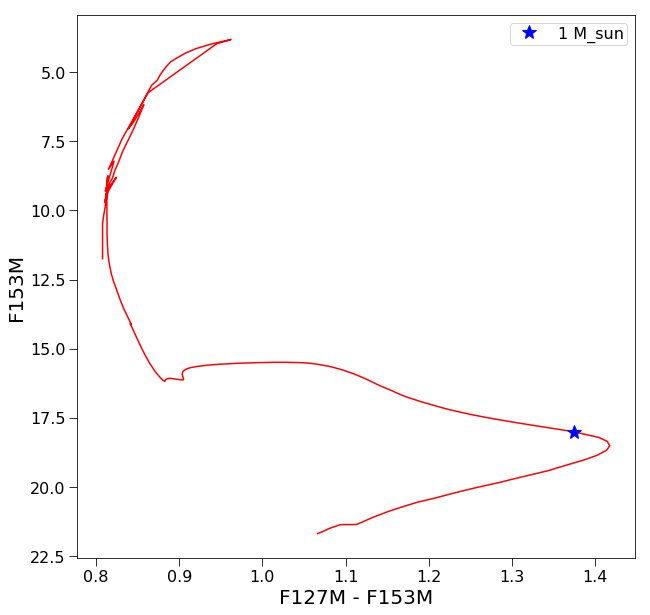

In [47]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 M_sun')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

PopStar offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can pass in a PopStar multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [6]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01
massLimits = np.array([0.08, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

## Note: there is a Kroupa_2001 IMF object in the popstar/imf.py that one could use
## to generate the Kroupa+01 IMF. However, the Kroupa_2001 IMF object contains masses
## down to 0.01 M_sun, which is beyond the lower limit of our isochrones. As a result,
## the synthetic photometry of these stars systems are non-sensical 
##
## If the user isn't interested in the photometry, then they could define the 
## IMF object as:
## my_imf = imf.Kroupa_2001(multiplicity=imf_multi)

### Step 3: Make the Cluster
To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined.

The individual star systems in the cluster and their properties are stored in an astropy table accessed by the star_systems subfunction on the cluster object. Note that the photometry of these star systems includes the contributions from all companions, which are generated probabilistically using the multiplicity defined in the IMF object.

In [7]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 37 stars out of mass range
        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
0.15322630034334855      False ... 20.531469742448504            0
 0.2514444248779253      False ... 19.841236982900842            0
 0.4065963465044797      False ...  19.14324955899695            0
0.14771352871210264      False ... 20.581792395873826            0
0.26375521526671486      False ...  19.77410116153889            0
 0.1672978556059946      False ... 20.413204498622274            0
0.09848478966762604      False ... 21.125387887411783            0
0.12591119150070063      False ... 20.799737530057705            0
0.11276573696455855      False ... 20.956809130424926            0
 0.2105314315057273      False ...  20.10179211864805            0
                ...        ... ...                ...          ...
0.17753945912947774      False ... 20.334008918508733            0
 0.3152647647595826      Fals

In [8]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


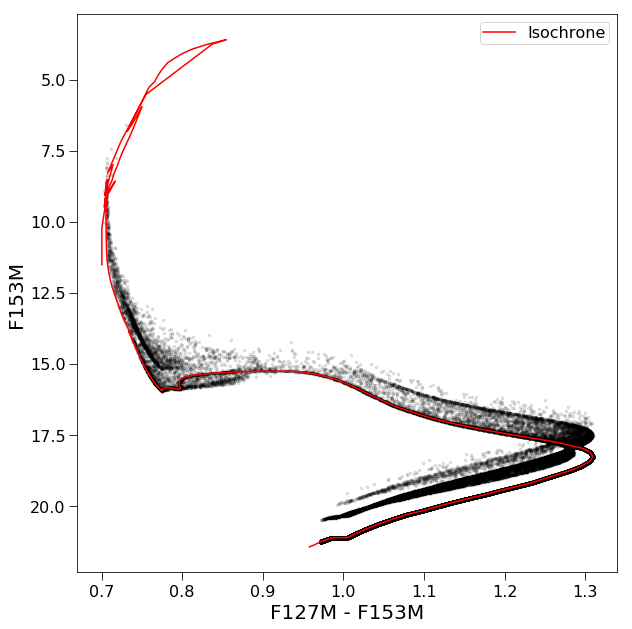

In [9]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()